In [1]:
import tensorflow as tf
from tqdm import trange
import sys
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from time import time
import datetime

from models.tfkeras_resnets import build_resnet, get_resnet_build_function, build_single_block_resnet, get_single_block_resnet_build_function
from dataset_utils.tf_dataset_preprocessors_image_classification import *
from dataset_utils.tfrecord_dataset_creator import TFRecordDatasetCreator, get_tfrecord_paths
from dataset_utils.cifar10_utils import build_cifar10_dataset
from dataset_utils.tf_dataset_creator_from_arrays import create_tf_dataset_from_arrays
from training.training import Training

%matplotlib inline

In [2]:
num_classes = 10
image_shape = (32, 32, 3)
num_layers = 64
final_time = 8
h = final_time / num_layers
num_filters = 16
kernel_type = 'antisymmetric'
model_name = 'single_block_{}_{}-layers_{}-filters'.format(kernel_type, num_layers, num_filters)

In [3]:
load_weights_h5_path = './local/models/weights_single_block_antisymmetric_64-layers_16-filters_200-steps.h5'
global_step = 0

In [3]:
cifar10_directory = '/pierluigiferrari/datasets/CIFAR-10_Python/'

train_images, train_labels, val_images, val_labels, label_names = build_cifar10_dataset(cifar10_directory)

In [4]:
cifar10_directory = '/pierluigiferrari/datasets/CIFAR-10_Python/'

train_images, train_labels, val_images, val_labels, label_names = build_cifar10_dataset(cifar10_directory)

batch_size = 32
prefetch = 10

convert_labels_to_one_hot = ConvertLabelsToOneHot(num_classes=10)

preprocessors = [convert_labels_to_one_hot]

(train_dataset,
 train_features_placeholder,
 train_labels_placeholder) = create_tf_dataset_from_arrays(features=train_images,
                                                           labels=train_labels,
                                                           batch_size=batch_size,
                                                           preprocessors=preprocessors,
                                                           repeat=True,
                                                           num_epochs=None,
                                                           shuffle=True,
                                                           prefetch=prefetch)

(val_dataset,
 val_features_placeholder,
 val_labels_placeholder) = create_tf_dataset_from_arrays(features=val_images,
                                                         labels=val_labels,
                                                         batch_size=batch_size,
                                                         preprocessors=preprocessors,
                                                         repeat=True,
                                                         num_epochs=None,
                                                         shuffle=True,
                                                         prefetch=prefetch)

In [5]:
model_build_function = get_single_block_resnet_build_function(kernel_type=kernel_type,
                                                              kernel_size=3,
                                                              h=h,
                                                              num_stages=2,
                                                              blocks_per_stage=[num_layers],
                                                              filters_per_block=[num_filters],
                                                              strides=[(1,1)],
                                                              include_top=True,
                                                              fc_activation='softmax',
                                                              num_classes=num_classes,
                                                              use_batch_norm=False,
                                                              use_max_pooling=[False, False, False, False],
                                                              l2_regularization=0.0,
                                                              subtract_mean=127.5,
                                                              divide_by_stddev=127.5,
                                                              verbose=True)

learning_rate_placeholder = tf.placeholder(dtype=tf.float32, shape=(), name='learning_rate_placeholder')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_placeholder, epsilon=1e-07)
#optimizer = tf.keras.optimizers.Adam()
#optimizer = tf.keras.optimizers.SGD()

In [6]:
start_time = time()
trainer = Training(model_build_function=model_build_function,
                   kernel_type=kernel_type,
                   optimizer=optimizer,
                   learning_rate_placeholder=learning_rate_placeholder,
                   train_dataset=train_dataset,
                   val_dataset=val_dataset,
                   dataset_type='arrays',
                   train_features_placeholder=train_features_placeholder,
                   train_labels_placeholder=train_labels_placeholder,
                   val_features_placeholder=val_features_placeholder,
                   val_labels_placeholder=val_labels_placeholder,
                   train_features=train_images,
                   train_labels=train_labels,
                   val_features=val_images,
                   val_labels=val_labels,
                   global_step=global_step,
                   num_layers=num_layers,
                   record_summaries=True,
                   summaries=['mean_gradient_norms'],
                   summaries_dir='./local/tensorboard_summaries',
                   summaries_name=model_name,
                   csv_logger_dir='./local/csv_logger',
                   csv_logger_name='gradient_history')
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

TensorFlow Version: 1.12.0
Building stage 1
Building identity block 2-1
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.12it/s]
Building identity block 2-2
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 13.75it/s]
Building identity block 2-3
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.57it/s]
Building identity block 2-4
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 11.43it/s]
Building identity block 2-5
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.30it/s]
Building identity block 2-6
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.58it/s]
Building identity block 2-7
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 13.11it/s]
Building identity block 2-8
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 13.35it/s]
Buil

In [7]:
start_time = time()
trainer.model.updates
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

[]

In [7]:
start_time = time()
trainer.model.load_weights(load_weights_h5_path)
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

Total time elapsed: 0:00:20 (h:m:s)


In [8]:
start_time = time()
trainer.train(epochs=1,
              steps_per_epoch=(50000+batch_size-1)//batch_size,
              learning_rate_schedule=lambda x: 0.001,
              eval_dataset='val',
              eval_frequency=1,
              eval_steps=(10000+batch_size-1)//batch_size,
              save_during_training=False,
              save_dir=None,
              save_best_only=True,
              save_tags=['default'],
              save_name='',
              save_frequency=5,
              saver='train_saver',
              monitor='loss',
              summaries_frequency=10)
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

Default GPU Device: /device:GPU:0
Evaluation on validation dataset: 100%|██████████| 313/313 [02:08<00:00,  4.08it/s, accuracy=0.319, mean_loss=1.83]
Total time elapsed: 0:24:35 (h:m:s)


In [9]:
save_weights_h5_path = './local/models/weights_{}_{}-steps_eval-loss-{:.2f}_eval-accuracy-{:.3f}.h5'.format(model_name, trainer.g_step, trainer.metric_values[0], trainer.metric_values[1])

In [10]:
trainer.model.save_weights(save_weights_h5_path)

In [4]:
model = build_single_block_resnet(image_shape=image_shape,
                                  kernel_type=kernel_type,
                                  kernel_size=3,
                                  h=h,
                                  num_stages=2,
                                  blocks_per_stage=[num_layers],
                                  filters_per_block=[num_filters],
                                  strides=[(1,1)],
                                  include_top=True,
                                  fc_activation='softmax',
                                  num_classes=num_classes,
                                  use_batch_norm=False,
                                  use_max_pooling=[False, False, False, False],
                                  l2_regularization=0.0,
                                  subtract_mean=127.5,
                                  divide_by_stddev=127.5,
                                  verbose=True)

Building stage 1
Building identity block 2-1
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.11it/s]
Building identity block 2-2
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 13.50it/s]
Building identity block 2-3
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 11.89it/s]
Building identity block 2-4
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.08it/s]
Building identity block 2-5
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 12.04it/s]
Building identity block 2-6
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00,  9.79it/s]
Building identity block 2-7
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 11.94it/s]
Building identity block 2-8
Building output channel filters for layer: 100%|██████████| 16/16 [00:01<00:00, 11.25it/s]
Building identity block 2-9
Bui

In [5]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
#model.load_weights(load_weights_h5_path)

In [7]:
print(model.optimizer)
print(model.loss_functions)
print(model.loss)
print(model.output)
print(model.updates)
print(model.state_updates)
print(model.losses)

[<function categorical_crossentropy at 0x7f7130d01a60>]
categorical_crossentropy
Tensor("fc/Softmax:0", shape=(?, 10), dtype=float32)
[]
[]
[<tf.Tensor 'Const_865:0' shape=() dtype=float32>, <tf.Tensor 'Const_1189:0' shape=() dtype=float32>, <tf.Tensor 'Const_770:0' shape=() dtype=float32>, <tf.Tensor 'Const_161:0' shape=() dtype=float32>, <tf.Tensor 'Const_228:0' shape=() dtype=float32>, <tf.Tensor 'Const_372:0' shape=() dtype=float32>, <tf.Tensor 'Const_552:0' shape=() dtype=float32>, <tf.Tensor 'Const_595:0' shape=() dtype=float32>, <tf.Tensor 'Const_702:0' shape=() dtype=float32>, <tf.Tensor 'Const_699:0' shape=() dtype=float32>, <tf.Tensor 'Const_1203:0' shape=() dtype=float32>, <tf.Tensor 'Const_844:0' shape=() dtype=float32>, <tf.Tensor 'Const_1024:0' shape=() dtype=float32>, <tf.Tensor 'Const_1180:0' shape=() dtype=float32>, <tf.Tensor 'Const_684:0' shape=() dtype=float32>, <tf.Tensor 'Const_1039:0' shape=() dtype=float32>, <tf.Tensor 'Const_387:0' shape=() dtype=float32>, <tf.

In [6]:
start_time = time()
history = model.fit(x=train_images[:6400],
                    y=tf.keras.utils.to_categorical(train_labels[:6400], num_classes=num_classes),
                    batch_size=32,
                    epochs=1,
                    verbose=1,
                    callbacks=None,
                    validation_data=None, #(val_images, tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)),
                    shuffle=True,
                    initial_epoch=0)
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

Epoch 1/1
6400/6400 [==============================] - 1019s 159ms/step - loss: 3.5780 - acc: 0.1445
Total time elapsed: 0:19:35 (h:m:s)


In [7]:
save_weights_h5_path = './local/models/weights_{}_200-steps.h5'.format(model_name)

In [8]:
model.save_weights(filepath=save_weights_h5_path)

In [16]:
start_time = time()

In [32]:
start_time = time()
end_time = time()
print("Total time elapsed: {} (h:m:s)".format(str(datetime.timedelta(seconds=int(end_time - start_time)))))

Total time elapsed: 0:00:00 (h:m:s)


In [27]:
history = model.fit(x=train_images,
                    y=tf.keras.utils.to_categorical(train_labels, num_classes=num_classes),
                    batch_size=32,
                    epochs=1,
                    verbose=1,
                    callbacks=None,
                    validation_data=(test_images, tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)),
                    shuffle=True,
                    initial_epoch=0)

NameError: name 'model' is not defined

In [10]:
# variable h at 32 layers

history = model.fit(x=train_images,
                    y=tf.keras.utils.to_categorical(train_labels, num_classes=num_classes),
                    batch_size=32,
                    epochs=1,
                    verbose=1,
                    callbacks=None,
                    validation_data=(test_images, tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)),
                    shuffle=True,
                    initial_epoch=0)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 44s 871us/step - loss: 1.3079 - acc: 0.5241 - val_loss: 1.2642 - val_acc: 0.5347


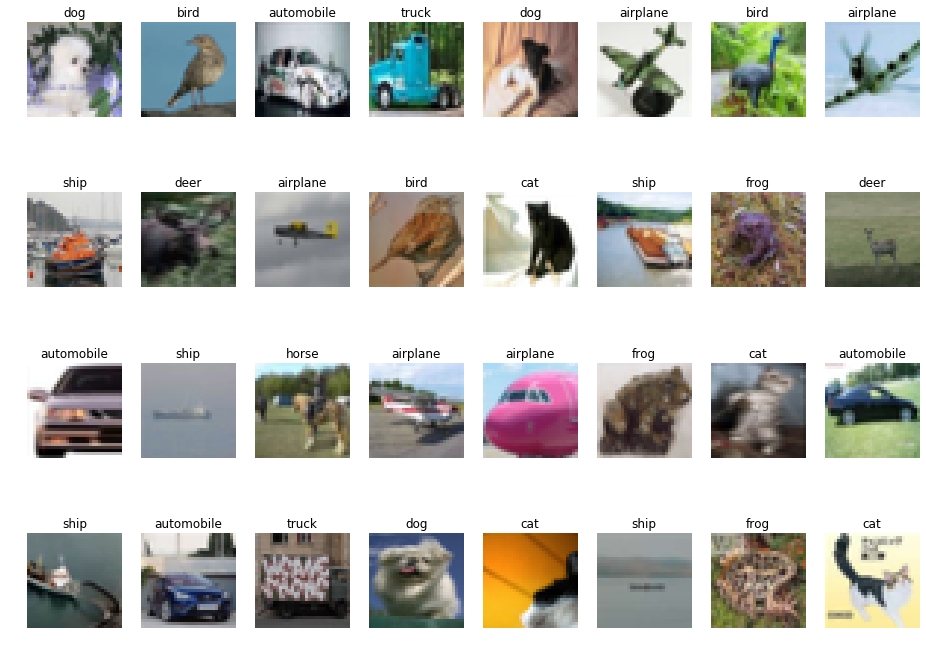

In [3]:
grid_m = 4
grid_n = 8

random_grid = np.random.randint(50000, size=[grid_m, grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(16,12))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(train_images[random_grid[i,j]].astype(np.uint8))
        cell0[i, j].axis('off')
        cell0[i, j].set_title(label_names[train_labels[random_grid[i,j]]])

In [2]:
num_classes = 257
image_shape = (224, 224, 3)

In [4]:
test_kernel = model.layers[12].get_kernel()

AttributeError: 'Conv2D' object has no attribute 'get_kernel'

In [9]:
print(test_kernel.shape)
print()
print(test_kernel[:,:,10,31])
print()
print(test_kernel[:,:,31,10])
print()
print(test_kernel[:,:,4,4])

(3, 3, 64, 64)

[[-0.02169081  0.01794118  0.07217322]
 [ 0.05354905  0.00966585  0.02776146]
 [ 0.00320099  0.10287603 -0.00396542]]

[[ 0.00396542 -0.10287603 -0.00320099]
 [-0.02776146 -0.00966585 -0.05354905]
 [-0.07217322 -0.01794118  0.02169081]]

[[ 0.04012137  0.02097436 -0.08360104]
 [ 0.03389134  0.         -0.03389134]
 [ 0.08360104 -0.02097436 -0.04012137]]


In [4]:
batch_size = 32
shuffle_buffer_size = 10000
num_parallel_reads = 4
num_parallel_calls = 4
prefetch = 10

train_directory = '/pierluigiferrari/datasets/Caltech256/train/'
val_directory = '/pierluigiferrari/datasets/Caltech256/val/'

feature_schema = {'image': tf.FixedLenFeature([], tf.string),
                  'filename': tf.FixedLenFeature([], tf.string),
                  'label': tf.FixedLenFeature([], tf.int64)}

unpack_images_labels = UnpackImagesLabels()
decode_images = DecodeJPEGImages(channels=3)
resize_with_pad = ResizeWithPad(target_size=image_shape[:2])
convert_labels_to_one_hot = ConvertLabelsToOneHot(num_classes=257)
random_flip_left_right = RandomFlipLeftRight()
random_brightness = RandomBrightness(max_delta=0.5)
random_saturation = RandomSaturation(lower=0.5, upper=1.5)

train_preprocessors = [unpack_images_labels,
                       decode_images,
                       random_flip_left_right,
                       resize_with_pad,
                       convert_labels_to_one_hot]

val_preprocessors = [unpack_images_labels,
                     decode_images,
                     resize_with_pad,
                     convert_labels_to_one_hot]

train_dataset_creator = TFRecordDatasetCreator(tfrecord_paths=get_tfrecord_paths(directory=train_directory, extension='tfrecord'),
                                               feature_schema=feature_schema,
                                               batch_size=batch_size,
                                               preprocessors=train_preprocessors,
                                               repeat=True,
                                               num_epochs=None,
                                               shuffle=True,
                                               shuffle_buffer_size=shuffle_buffer_size,
                                               num_parallel_reads=num_parallel_reads,
                                               num_parallel_calls=num_parallel_calls,
                                               prefetch=prefetch)

val_dataset_creator = TFRecordDatasetCreator(tfrecord_paths=get_tfrecord_paths(directory=val_directory, extension='tfrecord'),
                                             feature_schema=feature_schema,
                                             batch_size=batch_size,
                                             preprocessors=val_preprocessors,
                                             repeat=True,
                                             num_epochs=None,
                                             shuffle=False,
                                             shuffle_buffer_size=shuffle_buffer_size,
                                             num_parallel_reads=num_parallel_reads,
                                             num_parallel_calls=num_parallel_calls,
                                             prefetch=prefetch)

train_dataset = train_dataset_creator.create_dataset()
val_dataset = val_dataset_creator.create_dataset()

In [4]:
build_function = get_resnet_build_function(kernel_type='regular',#'antisymmetric',
                                           include_top=True,
                                           fc_activation='softmax',
                                           num_classes=num_classes,
                                           l2_regularization=0.0,
                                           subtract_mean=127.5,
                                           divide_by_stddev=127.5,
                                           version=1,
                                           preset='resnet50',
                                           blocks_per_stage=[1, 1, 1, 1],
                                           filters_per_block=[[64, 64, 128],
                                                              [64, 64, 256],
                                                              [128, 128, 512],
                                                              [256, 256, 1024]],
                                           use_batch_norm=True)

learning_rate = tf.placeholder(dtype=tf.float32, shape=(), name='learning_rate')
adam = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=1e-07)

In [5]:
trainer = Training(model_build_function=build_function,
                   optimizer=adam,
                   train_dataset=train_dataset,
                   val_dataset=val_dataset,
                   record_summaries=True,
                   summaries=['mean_gradient_norms'],
                   summaries_dir='./local',
                   summaries_name='tensorboard_summaries',
                   csv_logger_dir='./local/csv_logger',
                   csv_logger_name='gradient_history')

TensorFlow Version: 1.12.0


In [2]:
tf.enable_eager_execution()

def get_centrosymmetric_matrix(size,
                               in_channels,
                               rank=4,
                               prefix=None):
    
    if prefix is None: prefix = 'centro_sym'
    
    # We'll create a (anti-) centrosymmetric matrix from individual scalar TensorFlow variables.
    # We'll first store the references to these scalar variables in a Numpy array, then concatenate
    # them all to one tensor.
    variable_array = np.full(fill_value=None, shape=(size, size)) # Store references to scalar variables here.
    for i in range(size):
        for j in range(i, size): # Only half of the matrix entries are free variables.
            if j > i or (j == i and i <= size // 2 - 1):
                variable = self.add_weight(name='{}_{}_{}'.format(prefix, i, j),
                                           shape=[1,1] + [1] * (rank - 2),
                                           dtype=self.dtype,
                                           initializer=self.initializer,
                                           regularizer=self.kernel_regularizer,
                                           trainable=self.trainable)
                # This is the definition of (anti-) centrosymmetry:
                variable_array[i, j] = variable
                variable_array[size - 1 - i, size - 1 - j] = -variable if self.anti else variable
            elif j == i and i == size // 2 and size % 2 == 1: # For matrices of odd size, this is the central element.
                if self.anti:
                    # For the anti-centrosymmetric case, the center element must be zero.
                    # This also implies that this element must be non-trainable.
                    variable_array[i, j] = self.add_weight(name='{}_{}_{}'.format(prefix, i, j),
                                                           shape=[1,1] + [1] * (rank - 2),
                                                           dtype=self.dtype,
                                                           initializer=tf.initializers.zeros(dtype=self.dtype),
                                                           regularizer=None,
                                                           trainable=False) # Must be non-trainable.
                else:
                    variable_array[i, j] = self.add_weight(name='{}_{}_{}'.format(prefix, i, j),
                                                           shape=[1,1] + [1] * (rank - 2),
                                                           dtype=self.dtype,
                                                           initializer=self.initializer,
                                                           regularizer=self.kernel_regularizer,
                                                           trainable=self.trainable)
    
    variable_array = variable_array.tolist()
    variable_array = [tf.concat(var_list, axis=1) for var_list in variable_array]
    tensor = tf.concat(variable_array, axis=0)
    
    return tensor

In [3]:
matrix = get_centrosymmetric_matrix(size=3, in_channels=128, rank=4, anti=True)

print(matrix.shape)
print(matrix[:,:,0,0])

TypeError: get_centrosymmetric_matrix() got an unexpected keyword argument 'anti'

In [22]:
const = tf.constant(5)
var = tf.Variable(34.0)

print(const)
print(var)

tf.Tensor(5, shape=(), dtype=int32)
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=34.0>


In [10]:
num_channels = 128
kernel_size = 3

exchange_matrix = np.eye(kernel_size)[::-1]

A = np.array([[1.,2,3],[4,5,6],[7,8,9]])

A = np.array([[1.,2,3],[4,5,4],[3,2,1]])

A1 = np.matmul(A,exchange_matrix)

A2 = np.matmul(exchange_matrix, A)

A3 = np.matmul(exchange_matrix, A1)

print(A)
print()
print(A1)
print()
print(A2)
print()
print(A3)

[[1. 2. 3.]
 [4. 5. 4.]
 [3. 2. 1.]]

[[3. 2. 1.]
 [4. 5. 4.]
 [1. 2. 3.]]

[[3. 2. 1.]
 [4. 5. 4.]
 [1. 2. 3.]]

[[1. 2. 3.]
 [4. 5. 4.]
 [3. 2. 1.]]


In [57]:
def get_centrosymmetric_matrix(size, anti=True, rank=4, dtype=np.int, initializer=None, regularizer=None):
    
    matrix = np.full(fill_value=0.0, shape=[size, size] + [1] * (rank - 2), dtype=dtype)
    for i in range(size):
        for j in range(i, size):
            if j > i:
                initial_value = np.random.randint(low=0, high=100, dtype=dtype)
                matrix[i, j] = initial_value
                matrix[size - 1 - i, size - 1 - j] = -initial_value if anti else initial_value
            elif j == i and i <= (size - 1) // 2:
                initial_value = np.random.randint(low=0, high=100, dtype=dtype)
                matrix[i, j] = initial_value
                matrix[size - 1 - i, size - 1 - j] = -initial_value if anti else initial_value
                
    return matrix

In [58]:
print(get_centrosymmetric_matrix(size=7, anti=True)[:,:,0,0])

[[ 43  25  42   8  15  91  68]
 [-54  85  80  74  85  65  26]
 [-16 -21  30  73  37  97   4]
 [-29 -23 -93 -58  93  23  29]
 [ -4 -97 -37 -73 -30  21  16]
 [-26 -65 -85 -74 -80 -85  54]
 [-68 -91 -15  -8 -42 -25 -43]]


In [93]:
num_channels = 512
kernel_size = 3

exchange_matrix = np.eye(kernel_size)[::-1]

single_output_kernels = []
independent_kernels = []
for o in range(num_channels):
    # Independent kernels for this output channel
    num_independent = num_channels - o - 1 # The number of independent input channels for this output channel.
    independent_kernel = np.random.randint(low=0, high=100, size=[kernel_size, kernel_size, num_independent, 1])
    # Centrosymmetric kernel for this output channel
    centrosymmetric_kernel = get_centrosymmetric_matrix(size=kernel_size, anti=True)
    # Concat
    single_output_kernel = np.concatenate([centrosymmetric_kernel, independent_kernel], axis=2)
    # Dependent kernels for this output channel
    for i in range(o):
        centro_transpose = np.expand_dims(np.expand_dims(-np.matmul(exchange_matrix, np.matmul(independent_kernels[-(i+1)][:,:,i,0], exchange_matrix)), axis=-1), axis=-1)
        single_output_kernel = np.concatenate([centro_transpose, single_output_kernel], axis=2)
    single_output_kernels.append(single_output_kernel)
    independent_kernels.append(independent_kernel)
    #print(single_output_kernel.shape)
    
kernel = np.concatenate(single_output_kernels, axis=3)
print(kernel.shape)

(3, 3, 512, 512)


In [ ]:
num_channels = 512
kernel_size = 3

exchange_matrix = tf.constant(np.eye(kernel_size)[::-1], dtype=tf.float32)

single_output_kernels = []
independent_kernels = []
for o in range(num_channels):
    # Centrosymmetric kernel for this output channel
    centrosymmetric_kernel = self.get_centrosymmetric_matrix()
    # Independent kernels for this output channel
    num_independent = num_channels - o - 1 # The number of independent input channels for this output channel.
    if num_independent > 0:
        independent_kernel = self.add_weight(name='input_kernels_for_output_kernel_{}'.format(o),
                                             shape=[kernel_size, kernel_size, num_independent, 1],
                                             dtype=dtype,
                                             initializer=self.initializer,
                                             regularizer=self.kernel_regularizer,
                                             trainable=self.trainable)
        # Concatenate.
        single_output_kernel = tf.concat([centrosymmetric_kernel, independent_kernel], axis=2)
    else: # This case is for the very last output channel.
        single_output_kernel = centrosymmetric_kernel
    # Dependent kernels for this output channel
    for i in range(o):
        # Note: Multiplying by the exchange matrix to create the dependent kernels is not efficient,
        # but it makes creating the (anti-) symmetric kernels simpler and faster to initialize.
        # In a production system, however, the kernels should be transformed directly,
        # introducing unnecessary arithmetic operations.
        centro_transpose = tf.expand_dims(tf.expand_dims(-tf.matmul(exchange_matrix, tf.matmul(independent_kernels[-(i+1)][:,:,i,0], exchange_matrix)), axis=-1), axis=-1)
        single_output_kernel = tf.concat([centro_transpose, single_output_kernel], axis=2)
    single_output_kernels.append(single_output_kernel)
    if num_independent > 0:
        independent_kernels.append(independent_kernel)
    
kernel = tf.concat(single_output_kernels, axis=3)

In [12]:
print(np.concatenate([np.random.randint(low=0, high=100, size=[3, 3, 0, 1]),
                      np.random.randint(low=0, high=100, size=[3, 3, 3, 1])], axis=2).shape)

(3, 3, 3, 1)


In [ ]:
def get_centrosymmetric_matrix(size,
                               anti=True,
                               rank=4,
                               prefix=None):
    
    matrix = np.full(fill_value=None, shape=[size, size] + [1] * (rank - 2))
    for i in range(size):
        for j in range(i, size):
            if j > i or (j == i and i <= (size - 1) // 2):
                variable = self.add_weight(name='centro_{}_{}_{}'.format(prefix, i, j),
                                           shape=[1] * rank,
                                           dtype=self.dtype,
                                           initializer=self.initializer,
                                           regularizer=self.kernel_regularizer,
                                           trainable=self.trainable)
                matrix[i, j] = variable
                matrix[size - 1 - i, size - 1 - j] = -variable if anti else variable
                
    return matrix

In [ ]:
tf.enable_eager_execution()

num_channels = 512
kernel_size = 3

initializer = tf.initializers.truncated_normal(mean=0.0,
                                               stddev=tf.sqrt(2/(kernel_size * kernel_size * num_channels)),
                                               dtype=tf.float32)

def get_centrosymmetric_matrix(size,
                               anti=True,
                               rank=4,
                               prefix=None):
    
    if prefix is None: prefix = ''
    
    np_matrix = np.full(fill_value=None, shape=[size, size] + [1] * (rank - 2))
    for i in range(size):
        for j in range(i, size):
            if j > i or (j == i and i <= (size - 1) // 2):
                variable = tf.get_variable(name='centro_{}_{}_{}'.format(prefix, i, j),
                                           shape=[1] * rank,
                                           dtype=tf.float32,
                                           initializer=tf.initializers.truncated_normal(mean=0.0,
                                                                                        stddev=tf.sqrt(2/(kernel_size * kernel_size * num_channels)),
                                                                                        dtype=tf.float32),
                                           regularizer=None,
                                           trainable=True)
                np_matrix[i, j] = variable
                np_matrix[size - 1 - i, size - 1 - j] = -variable if anti else variable
                
    tf_matrix_rows = tf.concat(np_matrix, axis=1)
    tf_matrix = tf.concat(tf_matrix_rows, axis=0)
                
    return tf_matrix

exchange_matrix = np.eye(kernel_size)[::-1]

single_output_kernels = []
independent_kernels = []
for o in range(num_channels):
    # Independent kernels for this output channel
    num_independent = num_channels - o - 1 # The number of independent input channels for this output channel.
    independent_kernel = np.random.randint(low=0, high=100, size=[kernel_size, kernel_size, num_independent, 1])
    # Centrosymmetric kernel for this output channel
    centrosymmetric_kernel = get_centrosymmetric_matrix(size=kernel_size, anti=True)
    # Concat
    single_output_kernel = np.concatenate([centrosymmetric_kernel, independent_kernel], axis=2)
    # Dependent kernels for this output channel
    for i in range(o):
        centro_transpose = np.expand_dims(np.expand_dims(-np.matmul(exchange_matrix, np.matmul(independent_kernels[-(i+1)][:,:,i,0], exchange_matrix)), axis=-1), axis=-1)
        single_output_kernel = np.concatenate([centro_transpose, single_output_kernel], axis=2)
    single_output_kernels.append(single_output_kernel)
    independent_kernels.append(independent_kernel)
    #print(single_output_kernel.shape)
    
kernel = np.concatenate(single_output_kernels, axis=3)
print(kernel.shape)

In [91]:
print(kernel[:,:,0,0])
print()
print(kernel[:,:,1,0])
print()
print(kernel[:,:,0,1])
print()
print(kernel[:,:,100,100])
print()
print(kernel[:,:,14,234])
print()
print(kernel[:,:,234,14])

[[ 80.  26.  40.]
 [-98. -25.  98.]
 [-40. -26. -80.]]

[[63. 34. 92.]
 [94. 23. 38.]
 [67. 48. 13.]]

[[-13. -48. -67.]
 [-38. -23. -94.]
 [-92. -34. -63.]]

[[  8.  50.  31.]
 [-43. -95.  43.]
 [-31. -50.  -8.]]

[[-36. -54. -94.]
 [-16. -42. -45.]
 [-74. -53. -40.]]

[[40. 53. 74.]
 [45. 42. 16.]
 [94. 54. 36.]]


In [8]:
trainer.load_variables('./local/saved_model_(globalstep-3000)_(trainloss-4.7069)_(eval_on_val_dataset)_(mean_loss-4.5955)_(accuracy-0.1062)/variables')

INFO:tensorflow:Restoring parameters from ./local/saved_model_(globalstep-3000)_(trainloss-4.7069)_(eval_on_val_dataset)_(mean_loss-4.5955)_(accuracy-0.1062)/variables


In [14]:
trainer.train(epochs=3,
              steps_per_epoch=1000,
              learning_rate_schedule=lambda x: 0.001,
              eval_dataset='val',
              eval_frequency=1,
              eval_steps=240,
              save_during_training=False,
              save_dir=None,
              save_best_only=True,
              save_tags=['default'],
              save_name='',
              save_frequency=5,
              saver='train_saver',
              monitor='loss',
              summaries_frequency=10)

Default GPU Device: /device:GPU:0
Evaluation on validation dataset: 100%|██████████| 240/240 [00:37<00:00,  6.69it/s, mean_loss=4.4, accuracy=0.13]  


In [23]:
print(adam.get_slot_names())
m = adam.get_slot(var=trainer.model.variables[0], name='m')
print(m)

['m', 'v']
<tf.Variable 'conv1/kernel/Adam:0' shape=(7, 7, 3, 64) dtype=float32>


In [6]:
trainer.train(epochs=3,
              steps_per_epoch=1000,
              learning_rate_schedule=lambda x: 0.001,
              eval_dataset='val',
              eval_frequency=1,
              eval_steps=240,
              save_during_training=False,
              save_dir=None,
              save_best_only=True,
              save_tags=['default'],
              save_name='',
              save_frequency=5,
              saver='train_saver',
              monitor='loss',
              summaries_frequency=10)

Default GPU Device: /device:GPU:0
Evaluation on validation dataset: 100%|██████████| 240/240 [00:35<00:00,  6.72it/s, accuracy=0.131, mean_loss=4.32]


In [7]:
print(tf.keras.backend.epsilon())

1e-07


In [10]:
trainer.save(model_save_dir='./local/models/',
             name='resnet50',
             saver='train_saver')

In [7]:
import csv

gradient_norm_values = []
training_steps = []

with open('./local/csv_logger/gradient_history.csv', 'r') as history:
    
    csv_reader = csv.reader(history, delimiter=' ')
    header = next(csv_reader)
    for row in csv_reader:
        training_steps.append(int(row[0]))
        gradient_norm_values.append(np.array(row[1:], dtype=np.float))
        
gradient_norm_values = np.array(gradient_norm_values)
training_steps = np.array(training_steps)

In [8]:
print(gradient_norm_values.shape)

(747, 17)


In [9]:
layer = 0
start = 200
step = 10
x = np.arange(layer + 1, gradient_norm_values.shape[1] + 1)
y = training_steps[start::step]
x, y = np.meshgrid(x, y)
z = gradient_norm_values[start::step, layer:]

In [12]:
stds = np.std(z, axis=1)
print(stds*1e+06)

[  2.72555581   1.345796     1.86527187   2.11541074   6.87764957
   3.14286286   3.51046899   2.10420225   2.6694307    2.82828374
   5.46323184   6.49139633   3.50744235   4.36519576  12.00975868
   4.18812086  15.63972846   7.21275281 777.00763835 228.01958842
  14.05412567   6.13936696   7.02628522   9.25093441  15.78890923
  85.45285267  29.48006236  46.46685925   9.07572972  23.79514349
  18.61240534  75.42253866   7.12552956   7.63194553   5.56303555
   8.20633289  71.86181875  13.01049452  15.64023859   5.50621514
   7.27864758  10.26504214   6.6551108    2.77593887   4.49985054
   6.36631068   3.75077252   3.22783039   5.2586517    5.99526465
  12.37190139   5.08372213   8.28765916   8.9521695    8.2171498 ]


In [13]:
first_to_last_comparison = z[:,0] / z[:,1]
print(first_to_last_comparison)

[ 9.9788065   7.43705319  9.31421114  9.00992598  8.91960793 10.78264386
  6.17112305  7.71433012  6.23062689  5.14425428  9.35110355  5.30843822
  4.0409973   6.52728939 16.10731447  5.03935258 12.94459788  5.90063118
  4.61220537  5.34649846  4.82481112  3.91847301  4.37919546  6.60298295
  4.37724172  4.41838715  6.25083436  9.0938722  10.13721534  7.17855717
 13.10819314  7.66121635  7.62312908 11.15864589  6.31504937  7.88919972
  8.10944116 10.70014888  5.85872533  7.28656884 12.70380797  8.86871576
  7.99709754  5.26348409  8.60886002  8.81491487  5.08889767  4.73186022
  8.78056505  7.09220051  8.43875599  8.17223387  9.2433173   7.30372803
  9.40093252]


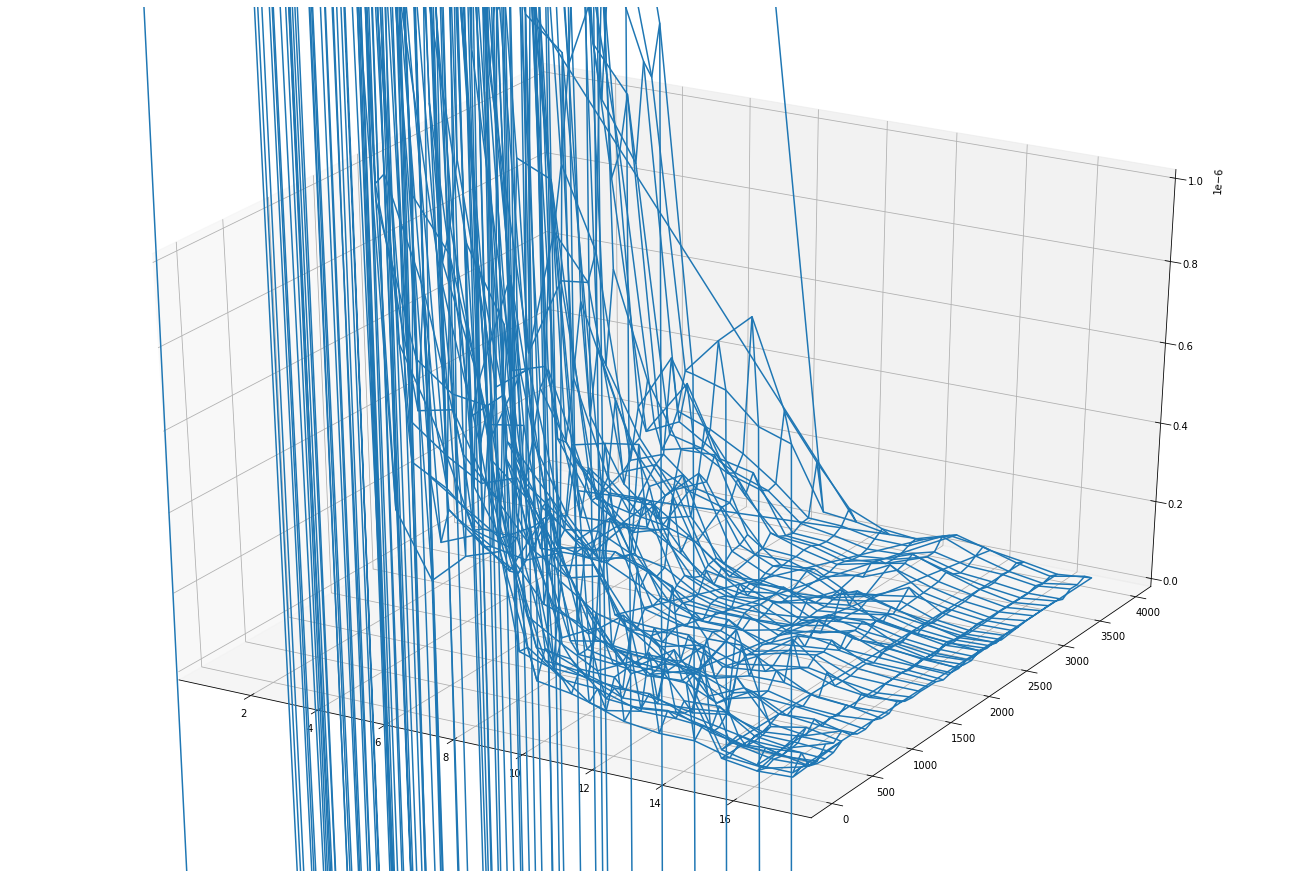

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(18,12))
ax = Axes3D(fig)

ax.plot_wireframe(x, y, z, rstride=1, cstride=1)
#surface_plot = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap=cm.coolwarm, antialiased=True)
#ax.zaxis._set_scale('log')
ax.ticklabel_format(axis='z', style='scientific', scilimits=(0,0))

# Customize the z axis.
ax.set_zlim3d(0.0, 1e-6)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surface_plot, shrink=0.5, aspect=5)

plt.show()

In [9]:
min_kernel_size = 3
min_kernel_rank = 1
valid_variable_types = ['kernel', 'bias']

for gradient, variable in trainer.grads_and_vars:
    variable_name = variable.name.split(':')[0]
    variable_type = variable_name.split('/')[-1]
    if (variable_type in valid_variable_types
        and variable.shape[0] >= min_kernel_size
        and len(variable.shape) >= min_kernel_rank):
        print(variable_name+'_gradient_mean_norm', variable.shape)

conv1/kernel_gradient_mean_norm (7, 7, 3, 64)
conv1/bias_gradient_mean_norm (64,)
res2_0_branch2a/bias_gradient_mean_norm (64,)
res2_0_branch2b/kernel_gradient_mean_norm (3, 3, 64, 64)
res2_0_branch2b/bias_gradient_mean_norm (64,)
res2_0_branch2c/bias_gradient_mean_norm (128,)
res2_0_branch1/bias_gradient_mean_norm (128,)
res3_0_branch2a/bias_gradient_mean_norm (64,)
res3_0_branch2b/kernel_gradient_mean_norm (3, 3, 64, 64)
res3_0_branch2b/bias_gradient_mean_norm (64,)
res3_0_branch2c/bias_gradient_mean_norm (256,)
res3_0_branch1/bias_gradient_mean_norm (256,)
res4_0_branch2a/bias_gradient_mean_norm (128,)
res4_0_branch2b/kernel_gradient_mean_norm (3, 3, 128, 128)
res4_0_branch2b/bias_gradient_mean_norm (128,)
res4_0_branch2c/bias_gradient_mean_norm (512,)
res4_0_branch1/bias_gradient_mean_norm (512,)
res5_0_branch2a/bias_gradient_mean_norm (256,)
res5_0_branch2b/kernel_gradient_mean_norm (3, 3, 256, 256)
res5_0_branch2b/bias_gradient_mean_norm (256,)
res5_0_branch2c/bias_gradient_mean_

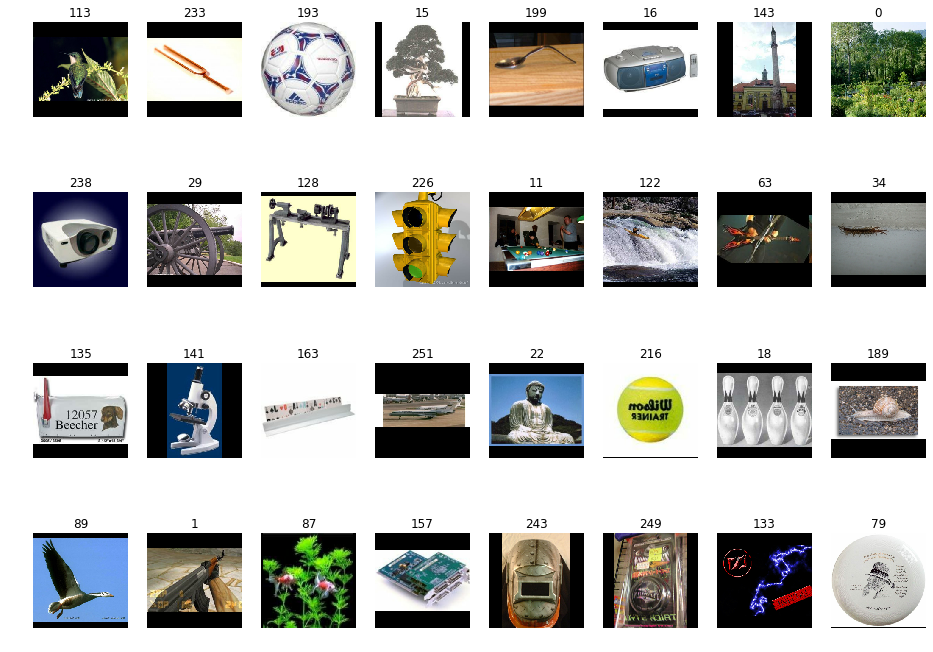

In [8]:
batch_images, batch_labels = sess.run([features, labels])

grid_m = 4
grid_n = 8

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(16,12))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(batch_images[i*grid_n+j].astype(np.uint8))
        cell0[i, j].axis('off')
        cell0[i, j].set_title(np.argmax(batch_labels[i*grid_n+j].astype(np.uint8)))

In [4]:
model = build_resnet(image_shape=image_shape,
                     kernel_type='regular',#'antisymmetric',
                     include_top=True,
                     fc_activation='softmax',
                     num_classes=num_classes,
                     l2_regularization=0.0,
                     subtract_mean=127.5,
                     divide_by_stddev=127.5,
                     version=1,
                     preset='resnet50',
                     blocks_per_stage=[2, 2, 2, 2],
                     filters_per_block=[[64, 64, 128],
                                        [64, 64, 256],
                                        [128, 128, 512],
                                        [256, 256, 1024]],
                     use_batch_norm=True)

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=1,
                    verbose=1,
                    callbacks=None,
                    initial_epoch=0,
                    steps_per_epoch=1000,
                    validation_data=val_dataset,
                    validation_steps=240)

Epoch 1/1
1000/1000 [==============================] - 236s 236ms/step - loss: 5.1533 - acc: 0.0653 - val_loss: 4.8341 - val_acc: 0.0853


In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 36s 0us/step


In [8]:
# antisymmetric 32 layers, 16 width

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=train_images,
                    y=tf.keras.utils.to_categorical(train_labels, num_classes=num_classes),
                    batch_size=32,
                    epochs=1,
                    verbose=1,
                    callbacks=None,
                    validation_data=(test_images, tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)),
                    shuffle=True,
                    initial_epoch=0)


Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 969s 19ms/step - loss: 1.5776 - acc: 0.4249 - val_loss: 2.3218 - val_acc: 0.2955


In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x=train_images,
                    y=tf.keras.utils.to_categorical(train_labels, num_classes=num_classes),
                    batch_size=32,
                    epochs=1,
                    verbose=1,
                    callbacks=None,
                    validation_data=(test_images, tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)),
                    shuffle=True,
                    initial_epoch=0)

Train on 50000 samples, validate on 10000 samples
Epoch 1/1
50000/50000 [==============================] - 68s 1ms/step - loss: 1.7405 - acc: 0.3791 - val_loss: 1.9218 - val_acc: 0.3606
